In [2]:
import sys
import os
import itertools

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scipy.optimize as spopt
import scipy.integrate as spi
import scipy.stats as stats

import tensorflow as tf
import pandas as pd

sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("../")
import util
import plotutils as pu

%matplotlib inline

In [3]:
config = "ns_3_mreg_3_msub_0_nf_32"
conn = "linw"
preproc = "dicer"
modelname1 = "AB"
modelname2 = "AN"

ds = ndsv.Dataset.from_file(f"../run/hcp/hcp100_{conn}_{preproc}/dataset.npz")

run1 = util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname1, config, [0,1], "hcp")
run2 = util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname2, config, [0,1], "hcp")

direc1 = f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname1}/{config}/run{run1:02d}"
direc2 = f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname1}/{config}/run{run2:02d}"

params1 = util.load_params(os.path.join(direc1, "parameters"), np.r_[:100])
params2 = util.load_params(os.path.join(direc2, "parameters"), np.r_[:100])

model1 = util.get_model(modelname1, config, ds)
model1.load_weights(f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname1}/{config}/run{run1:02d}/fit/model")

model2 = util.get_model(modelname2, config, ds)
model2.load_weights(f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname2}/{config}/run{run2:02d}/fit/model")

2022-08-30 19:05:04.138284: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 19:05:04.162619: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3399905000 Hz
2022-08-30 19:05:04.163883: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564c4acec5f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-30 19:05:04.163928: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-30 19:05:04.164180: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
nsub, nreg, _, nt = ds.y.shape
ntd = int(nt//3)

In [5]:
def simulate_variants(model, params, isub, nsamples, seed=0):
    # With network, with external input
    if model.shared_input:    
        np.random.seed(seed)
        sims1 = model.simulate_subjects(ds.w[[isub]], nt+ntd, thetareg=params.thetareg[[isub]], thetasub=None,
                                        us=None, n=nsamples)
        y1 = sims1.y.numpy()[:,0,:,0,-nt:]

    # Without network, with external input
    if model.shared_input:
        np.random.seed(seed)
        sims2 = model.simulate_subjects(0 * ds.w[[isub]], nt+ntd, thetareg=params.thetareg[[isub]], thetasub=None,
                                        us=None, n=nsamples)
        y2 = sims2.y.numpy()[:,0,:,0,-nt:]

    # With network, without external input
    np.random.seed(seed)
    us = np.zeros((1, nt+ntd, 2)) # zero mean and zero standard deviation
    sims3 = model.simulate_subjects(ds.w[[isub]], nt+ntd, thetareg=params.thetareg[[isub]], thetasub=None,
                                    us=us, n=nsamples)
    y3 = sims3.y.numpy()[:,0,:,0,-nt:]

    # Without network, without external input
    np.random.seed(seed)
    us = np.zeros((1, nt+ntd, 2)) # zero mean and zero standard deviation
    sims4 = model.simulate_subjects(0 * ds.w[[isub]], nt+ntd, thetareg=params.thetareg[[isub]], thetasub=None,
                                    us=us, n=nsamples)
    y4 = sims4.y.numpy()[:,0,:,0,-nt:]
    
    if model.shared_input:
        return (y1, y2, y3, y4), (sims1, sims2, sims3, sims4)
    else:
        return (None, None, y3, y4), (None, None, sims3, sims4)

In [ ]:
nsamples = 20

triu = np.triu_indices(nreg, k=1)
rows = []

for isub in range(nsub):
    print(isub, end=' ', flush=True)
    ys1, _ = simulate_variants(model1, params1, isub, nsamples=nsamples)
    ys2, _ = simulate_variants(model2, params2, isub, nsamples=nsamples)
    
    for isim in range(nsamples):
        yp1 = np.array([ds.y[isub,:,0,:]] + [y[isim]                            for y in ys1])
        yp2 = np.array([ds.y[isub,:,0,:]] + [y[isim] if y is not None else None for y in ys2])

        fcs1 = [np.corrcoef(y)[triu]                            for y in yp1]
        fcs2 = [np.corrcoef(y)[triu] if y is not None else None for y in yp2]
       
        row = {'isub': isub, 'isim': isim}
       
        row.update({"mean_0": np.mean(fcs1[0])})
        row.update({f"mean_{i}A": np.mean(fcs1[i]) for i in range(1,5)})
        row.update({f"mean_{i}B": np.mean(fcs2[i]) for i in range(3,5)})
        
        row.update({f"pc_{i}A": np.corrcoef(fcs1[0], fcs1[i])[1,0] for i in range(1,5)})
        row.update({f"pc_{i}B": np.corrcoef(fcs1[0], fcs2[i])[1,0] for i in range(3,5)})
        
        row.update({f"l2_{i}A": np.linalg.norm(fcs1[0] - fcs1[i]) for i in range(1,5)})
        row.update({f"l2_{i}B": np.linalg.norm(fcs1[0] - fcs2[i]) for i in range(3,5)})
        
        rows.append(row)
        
df = pd.DataFrame(rows)

df.to_csv("res/functional_connectivity.csv")

In [6]:
df = pd.read_csv("res/functional_connectivity.csv")

In [7]:
dfg = df.groupby('isub').agg({**{f'mean_0':    'mean'},
                              **{f'mean_{i}A': 'mean' for i in range(1,5)},
                              **{f'mean_{i}B': 'mean' for i in range(3,5)},
                              **{f'pc_{i}A':   'mean' for i in range(1,5)},
                              **{f'pc_{i}B':   'mean' for i in range(3,5)},
                             })

## Plotting

In [8]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

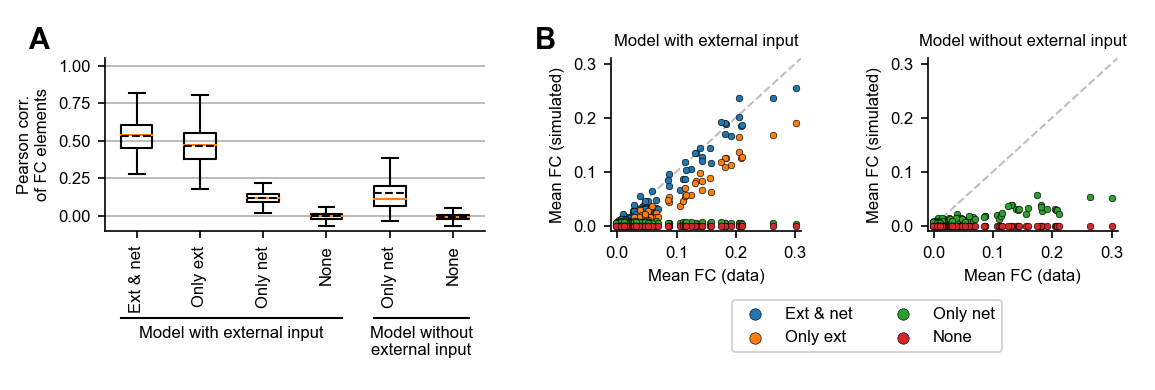

In [20]:
plt.figure(figsize=(7.5,2.4), dpi=150)

gs = GridSpec(nrows=1, ncols=3, width_ratios=[2, 1, 1], wspace=0.5, 
              left=0.08, right=0.98, top=0.88, bottom=0.4)
axes = []

# ----------------------------------------------
ax = plt.subplot(gs[0])

x = [df[f"pc_{i}A"] for i in range(1,5)] + [df[f"pc_{i}B"] for i in range(3,5)]
plt.boxplot(x, positions=np.r_[1:7], showfliers=False, showmeans=True, meanline=True, meanprops={'color':'k'});

plt.xticks(np.concatenate([np.r_[1:7]]), ["Ext & net", "Only ext", "Only net", "None", "Only net", "None"],
          rotation='vertical'
          )

ypos = -0.68
plt.plot([0.75, 4.25], [ypos, ypos], color='k', lw=1, clip_on=False)
plt.plot([4.75, 6.25], [ypos, ypos], color='k', lw=1, clip_on=False)
plt.text(2.5, ypos-0.05, "Model with external input", ha='center', va='top', fontsize=8)
plt.text(5.5, ypos-0.05, "Model without\nexternal input", ha='center', va='top', fontsize=8)
plt.grid(axis='y')
plt.ylim(-0.1, 1.05)
plt.ylabel("Pearson corr.\nof FC elements")
pu.bottomleft_spines(ax)
axes.append(ax)

# -----------------------------------------------
ax = plt.subplot(gs[1])
plt.title("Model with external input")
plt.scatter(dfg.mean_0, dfg.mean_1A, s=10, ec='k', lw=0.3, label="Ext & net")
plt.scatter(dfg.mean_0, dfg.mean_2A, s=10, ec='k', lw=0.3, label="Only ext")
plt.scatter(dfg.mean_0, dfg.mean_3A, s=10, ec='k', lw=0.3, label="Only net")
plt.scatter(dfg.mean_0, dfg.mean_4A, s=10, ec='k', lw=0.3, label="None")

plt.xlim(-0.01, 0.31)
plt.ylim(-0.01, 0.31)
plt.plot([0., 0.31], [0., 0.31], ls='--', lw=1, color='0.75', zorder=-5)
plt.xticks([0., 0.1, 0.2, 0.3])
plt.yticks([0., 0.1, 0.2, 0.3])
plt.xlabel("Mean FC (data)")
plt.ylabel("Mean FC (simulated)")
pu.bottomleft_spines(ax)
axes.append(ax)

leg = plt.legend(bbox_to_anchor=(2.1, -0.35), ncol=2)
for handle in leg.legendHandles:
    handle._sizes = [30]

# -----------------------------------------------
ax = plt.subplot(gs[2])
plt.title("Model without external input")
plt.scatter(dfg.mean_0, dfg.mean_3B, s=10, ec='k', lw=0.3, label="Only net", color='tab:green')
plt.scatter(dfg.mean_0, dfg.mean_4B, s=10, ec='k', lw=0.3, label="None",     color='tab:red')

# plt.legend(loc='upper left')
plt.xlim(-0.01, 0.31)
plt.ylim(-0.01, 0.31)
plt.plot([0., 0.31], [0., 0.31], ls='--', lw=1, color='0.75', zorder=-5)
plt.xticks([0., 0.1, 0.2, 0.3])
plt.yticks([0., 0.1, 0.2, 0.3])
plt.xlabel("Mean FC (data)")
plt.ylabel("Mean FC (simulated)")

pu.bottomleft_spines(ax)


bg = pu.Background(visible=False)
pu.add_panel_labels(axes=axes, fontsize=14, xs=[-0.2, -0.4], ys=1.02)
plt.savefig("img/Fig_HCP-network.pdf")

In [16]:
n = len(x)
pvals = np.full((n,n), np.nan)

for i in range(n):
    for j in range(i+1, n):
        tval, pvals[i,j] = stats.ttest_ind(x[i], x[j])

In [17]:
labels = ["With input, Ext & net",
          "With input, Only ext",
          "With input, Only net",
          "With input, None",
          "Without input, Only net",
          "Without input, None"]

/tmp/ipykernel_12037/4083776805.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  current_cmap.set_bad(color='0.7')
/tmp/ipykernel_12037/4083776805.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(pvals.T), vmin=-10, vmax=0)


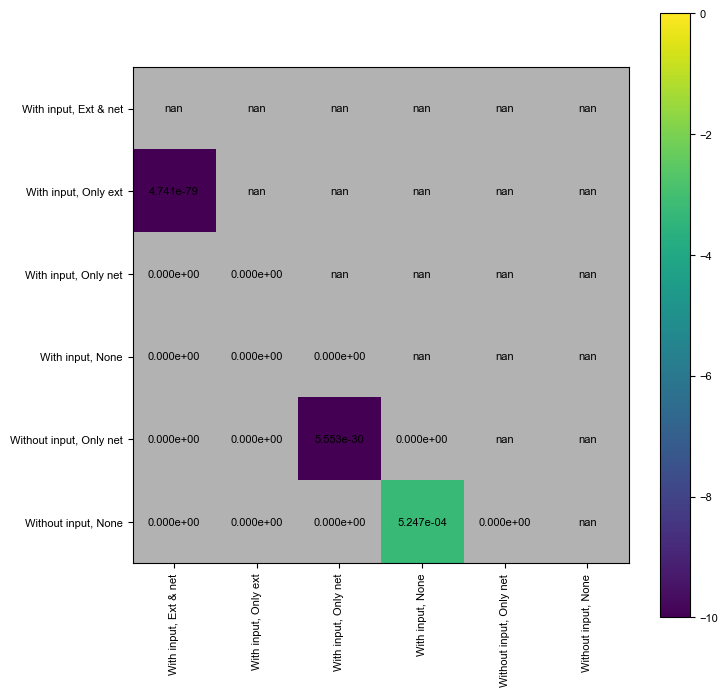

In [18]:
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='0.7')

plt.figure(figsize=(8,8), dpi=100)
plt.imshow(np.log10(pvals.T), vmin=-10, vmax=0)
plt.colorbar()
for i in range(n):
    for j in range(n):
        plt.text(i, j, f"{pvals[i,j]:.3e}", ha='center', va='center')
        
plt.xticks(np.r_[:n], labels, rotation='vertical')
plt.yticks(np.r_[:n], labels);

In [19]:
for i, l in enumerate(labels):
    print(f"{l:25}:   {np.mean(x[i]):8.5f}")

With input, Ext & net    :    0.52943
With input, Only ext     :    0.46248
With input, Only net     :    0.11960
With input, None         :   -0.00342
Without input, Only net  :    0.15280
Without input, None      :   -0.00588
